In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Unzip the dataset
!unzip "/content/drive/MyDrive/Concrete Crack Detection.zip" -d "/content/crack_dataset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/crack_dataset/Positive/15001_1.jpg  
  inflating: /content/crack_dataset/Positive/15002_1.jpg  
  inflating: /content/crack_dataset/Positive/15003_1.jpg  
  inflating: /content/crack_dataset/Positive/15004_1.jpg  
  inflating: /content/crack_dataset/Positive/15005_1.jpg  
  inflating: /content/crack_dataset/Positive/15006_1.jpg  
  inflating: /content/crack_dataset/Positive/15007_1.jpg  
  inflating: /content/crack_dataset/Positive/15008_1.jpg  
  inflating: /content/crack_dataset/Positive/15009_1.jpg  
  inflating: /content/crack_dataset/Positive/15010_1.jpg  
  inflating: /content/crack_dataset/Positive/15011_1.jpg  
  inflating: /content/crack_dataset/Positive/15012_1.jpg  
  inflating: /content/crack_dataset/Positive/15013_1.jpg  
  inflating: /content/crack_dataset/Positive/15014_1.jpg  
  inflating: /content/crack_dataset/Positive/15015_1.jpg  
  inflating: /content/crack_dataset/Positive/15016_1.jpg  
  inf

In [4]:
## Setup Image Transformations & Dataset Class

In [5]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Basic preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # for grayscale normalization
])

# Load dataset using ImageFolder (auto labels from folder names)
dataset = ImageFolder(root="/content/crack_dataset", transform=transform)

# Split: 80% train, 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [6]:
##Load & Modify ResNet50

In [7]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet50
model = models.resnet50(pretrained=True)

# Freeze feature layers (optional)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 classes: crack, no crack

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 91.9MB/s]


In [8]:
### Loss Function & Optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [10]:
## Training Loop (5 Epochs)

In [11]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {train_acc:.2f}%")


Epoch [1/5], Loss: 65.5415, Accuracy: 98.13%
Epoch [2/5], Loss: 31.2892, Accuracy: 98.97%
Epoch [3/5], Loss: 30.4561, Accuracy: 98.94%
Epoch [4/5], Loss: 26.1596, Accuracy: 99.12%
Epoch [5/5], Loss: 24.9936, Accuracy: 99.13%


In [12]:
## Validation Accuracy + Confusion Matrix


In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()
val_correct = 0
val_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

val_acc = 100 * val_correct / val_total
print(f"Validation Accuracy: {val_acc:.2f}%")


Validation Accuracy: 99.67%


In [14]:
##  Confusion Matrix Visualization

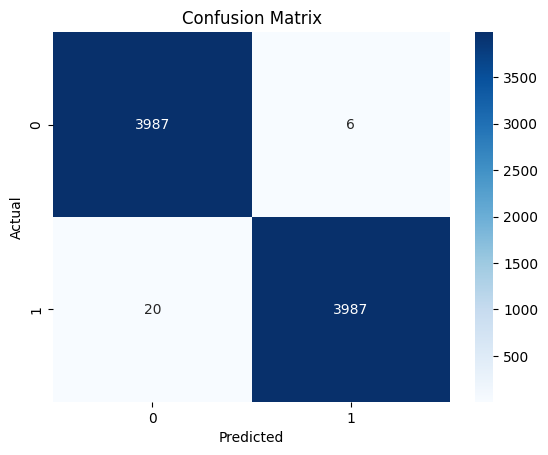


Classification Report:

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      3993
    Positive       1.00      1.00      1.00      4007

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [15]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))


In [16]:
## Visualize Sample Predictions

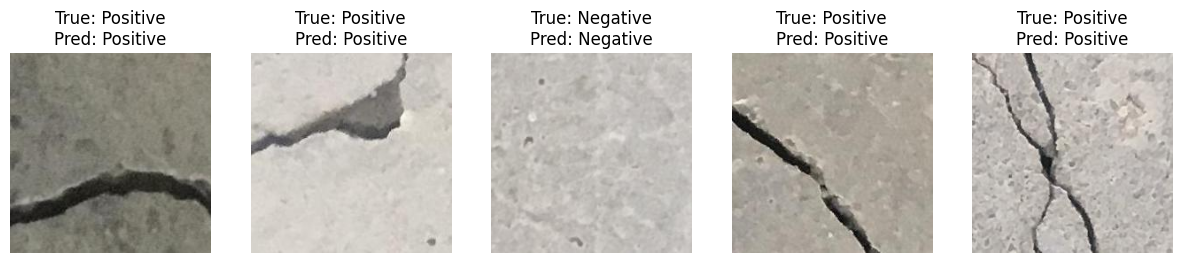

In [17]:
import random

# Show 5 random predictions from val set
model.eval()
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for ax in axes:
    idx = random.randint(0, len(val_dataset) - 1)
    image, label = val_dataset[idx]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_input)
        _, pred = torch.max(output, 1)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    ax.set_title(f"True: {dataset.classes[label]}\nPred: {dataset.classes[pred.item()]}")
    ax.axis('off')
